In [1]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split


import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Topline EDA

In [2]:
df = pd.read_csv("movie_df.csv")
df.drop("Unnamed: 0", axis =1, inplace=True)
df["release_date"] = pd.to_datetime(df.release_date, format="%Y-%m-%d")

In [51]:
df["infl._adj._dom._bo"].describe()

count    1.481000e+03
mean     2.185987e+07
std      6.937688e+07
min      4.490000e+02
25%      3.900300e+04
50%      3.510190e+05
75%      7.732249e+06
max      8.583730e+08
Name: infl._adj._dom._bo, dtype: float64

In [3]:
#adding mean box office by distro company
avg_gross_movie = df.groupby("distributor")["infl._adj._dom._bo"].mean()
df = pd.merge(df, avg_gross_movie, how='left',
              on='distributor')
df.rename(columns= {"infl._adj._dom._bo_y": "distributor_mean_gross",  
                    "infl._adj._dom._bo_x":"infl_bo"}, inplace=True)

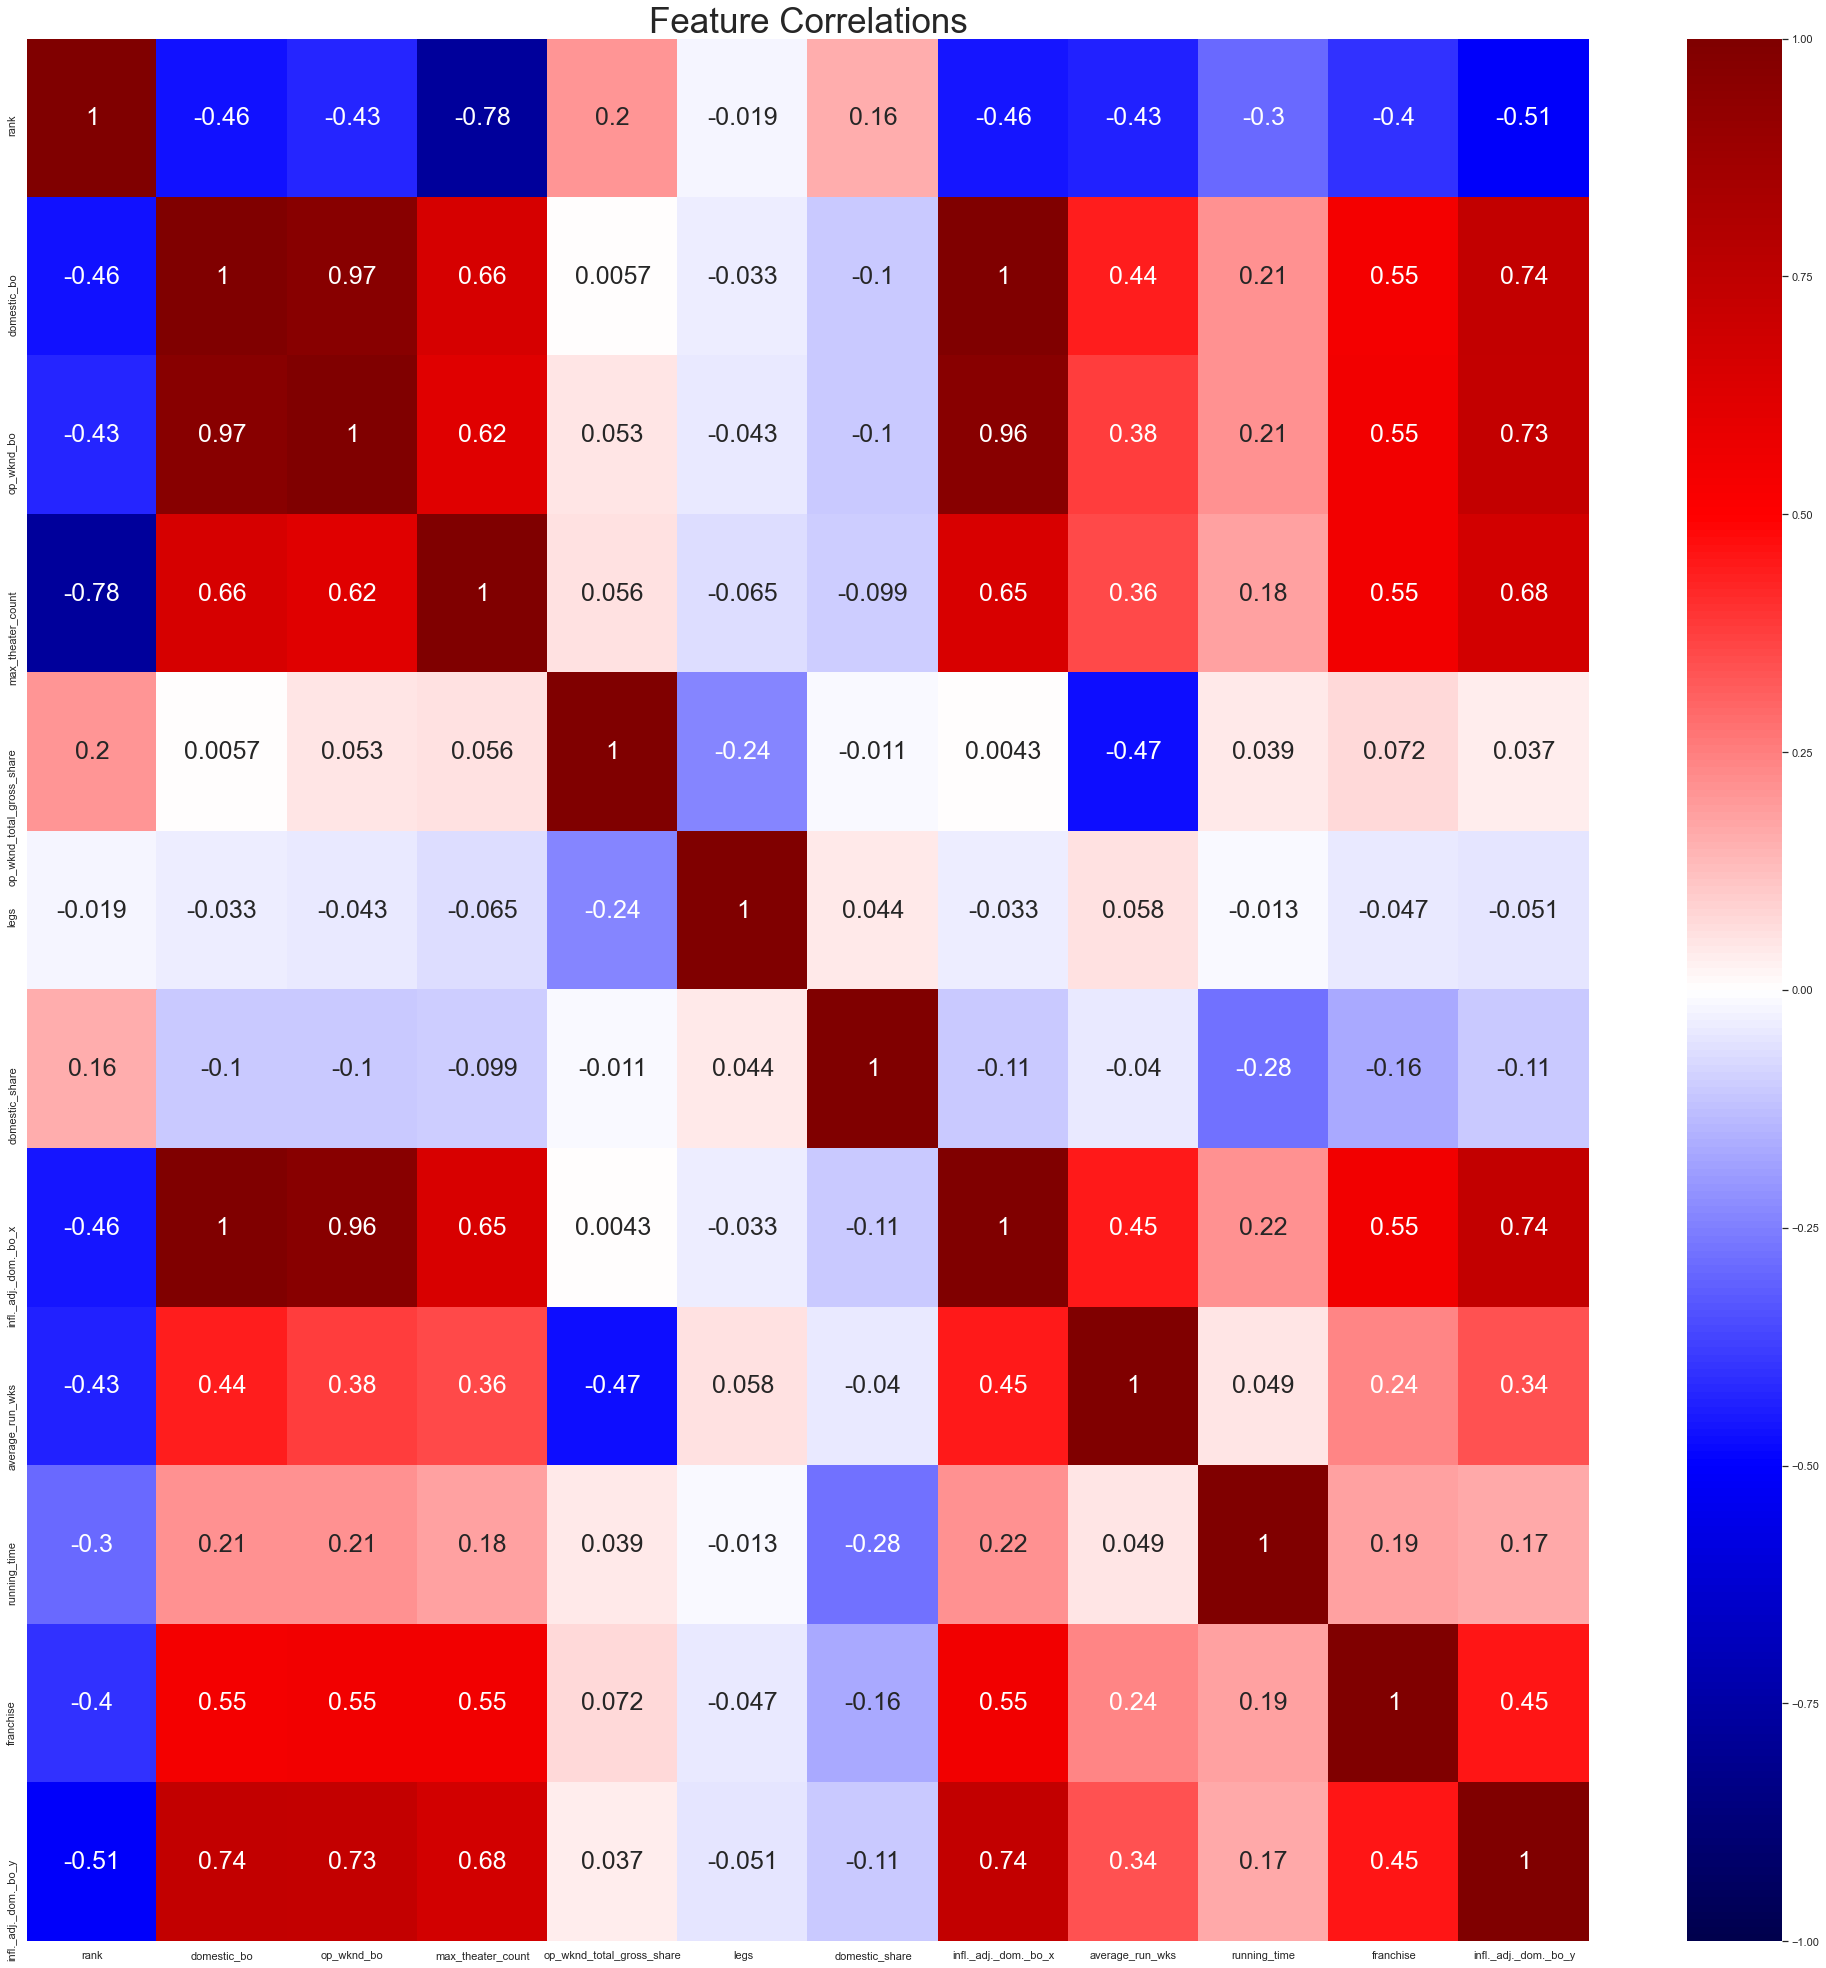

In [7]:
#plotting a heatmap of feature correlations 
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1,
            vmax=1, annot_kws={"size":25})
sns.set(rc={'figure.figsize':(35,35)})
plt.title("figures/Feature Correlations", fontsize =35);

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481 entries, 0 to 1480
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   rank                       1481 non-null   int64         
 1   movie                      1481 non-null   object        
 2   distributor                1481 non-null   object        
 3   domestic_bo                1481 non-null   int64         
 4   op_wknd_bo                 1481 non-null   float64       
 5   max_theater_count          1481 non-null   float64       
 6   director                   1481 non-null   object        
 7   lead_actor                 1481 non-null   object        
 8   op_wknd_total_gross_share  1481 non-null   float64       
 9   legs                       1481 non-null   float64       
 10  domestic_share             1481 non-null   float64       
 11  infl_bo                    1481 non-null   int64         
 12  averag

In [3]:
#columns with correlations of less than 0.5 with target inflation-adjusted box office:
features = ["op_wknd_total_gross_share", "legs", "domestic_share", "running_time"]

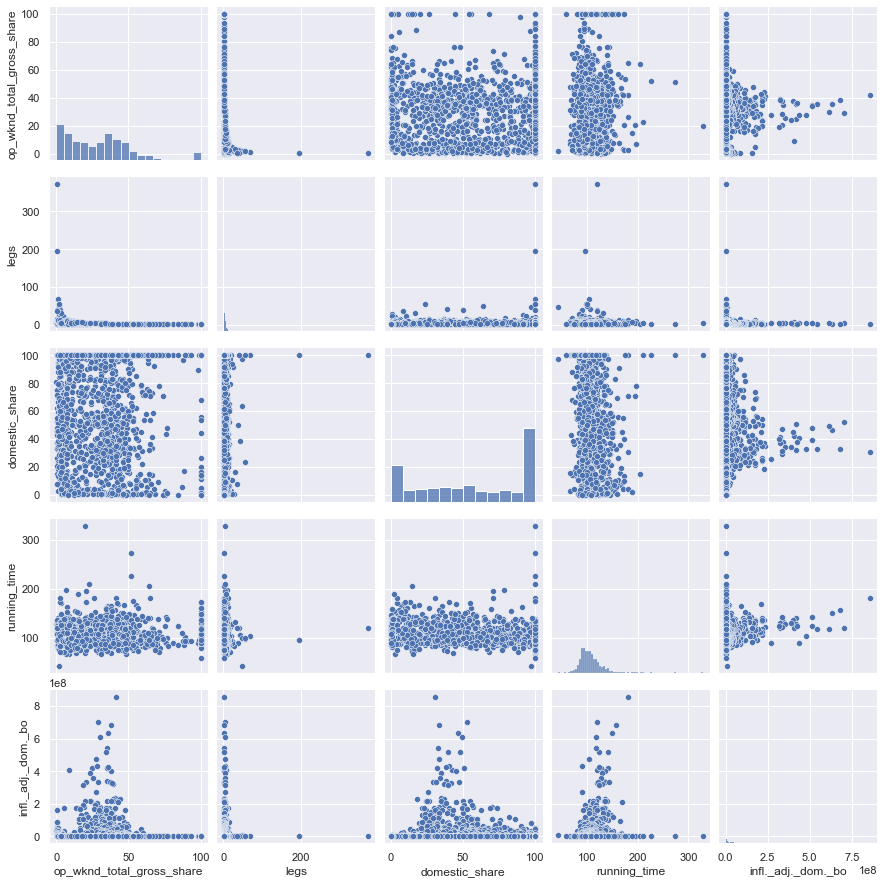

In [84]:
#pairplot
sns.pairplot(df[["op_wknd_total_gross_share", "legs", "domestic_share", "running_time", "infl._adj._dom._bo"]])
sns.set(rc={'figure.figsize':(35,35)})
plt.savefig("figures/features_pairplt.png");



<AxesSubplot:xlabel='infl_bo', ylabel='Count'>

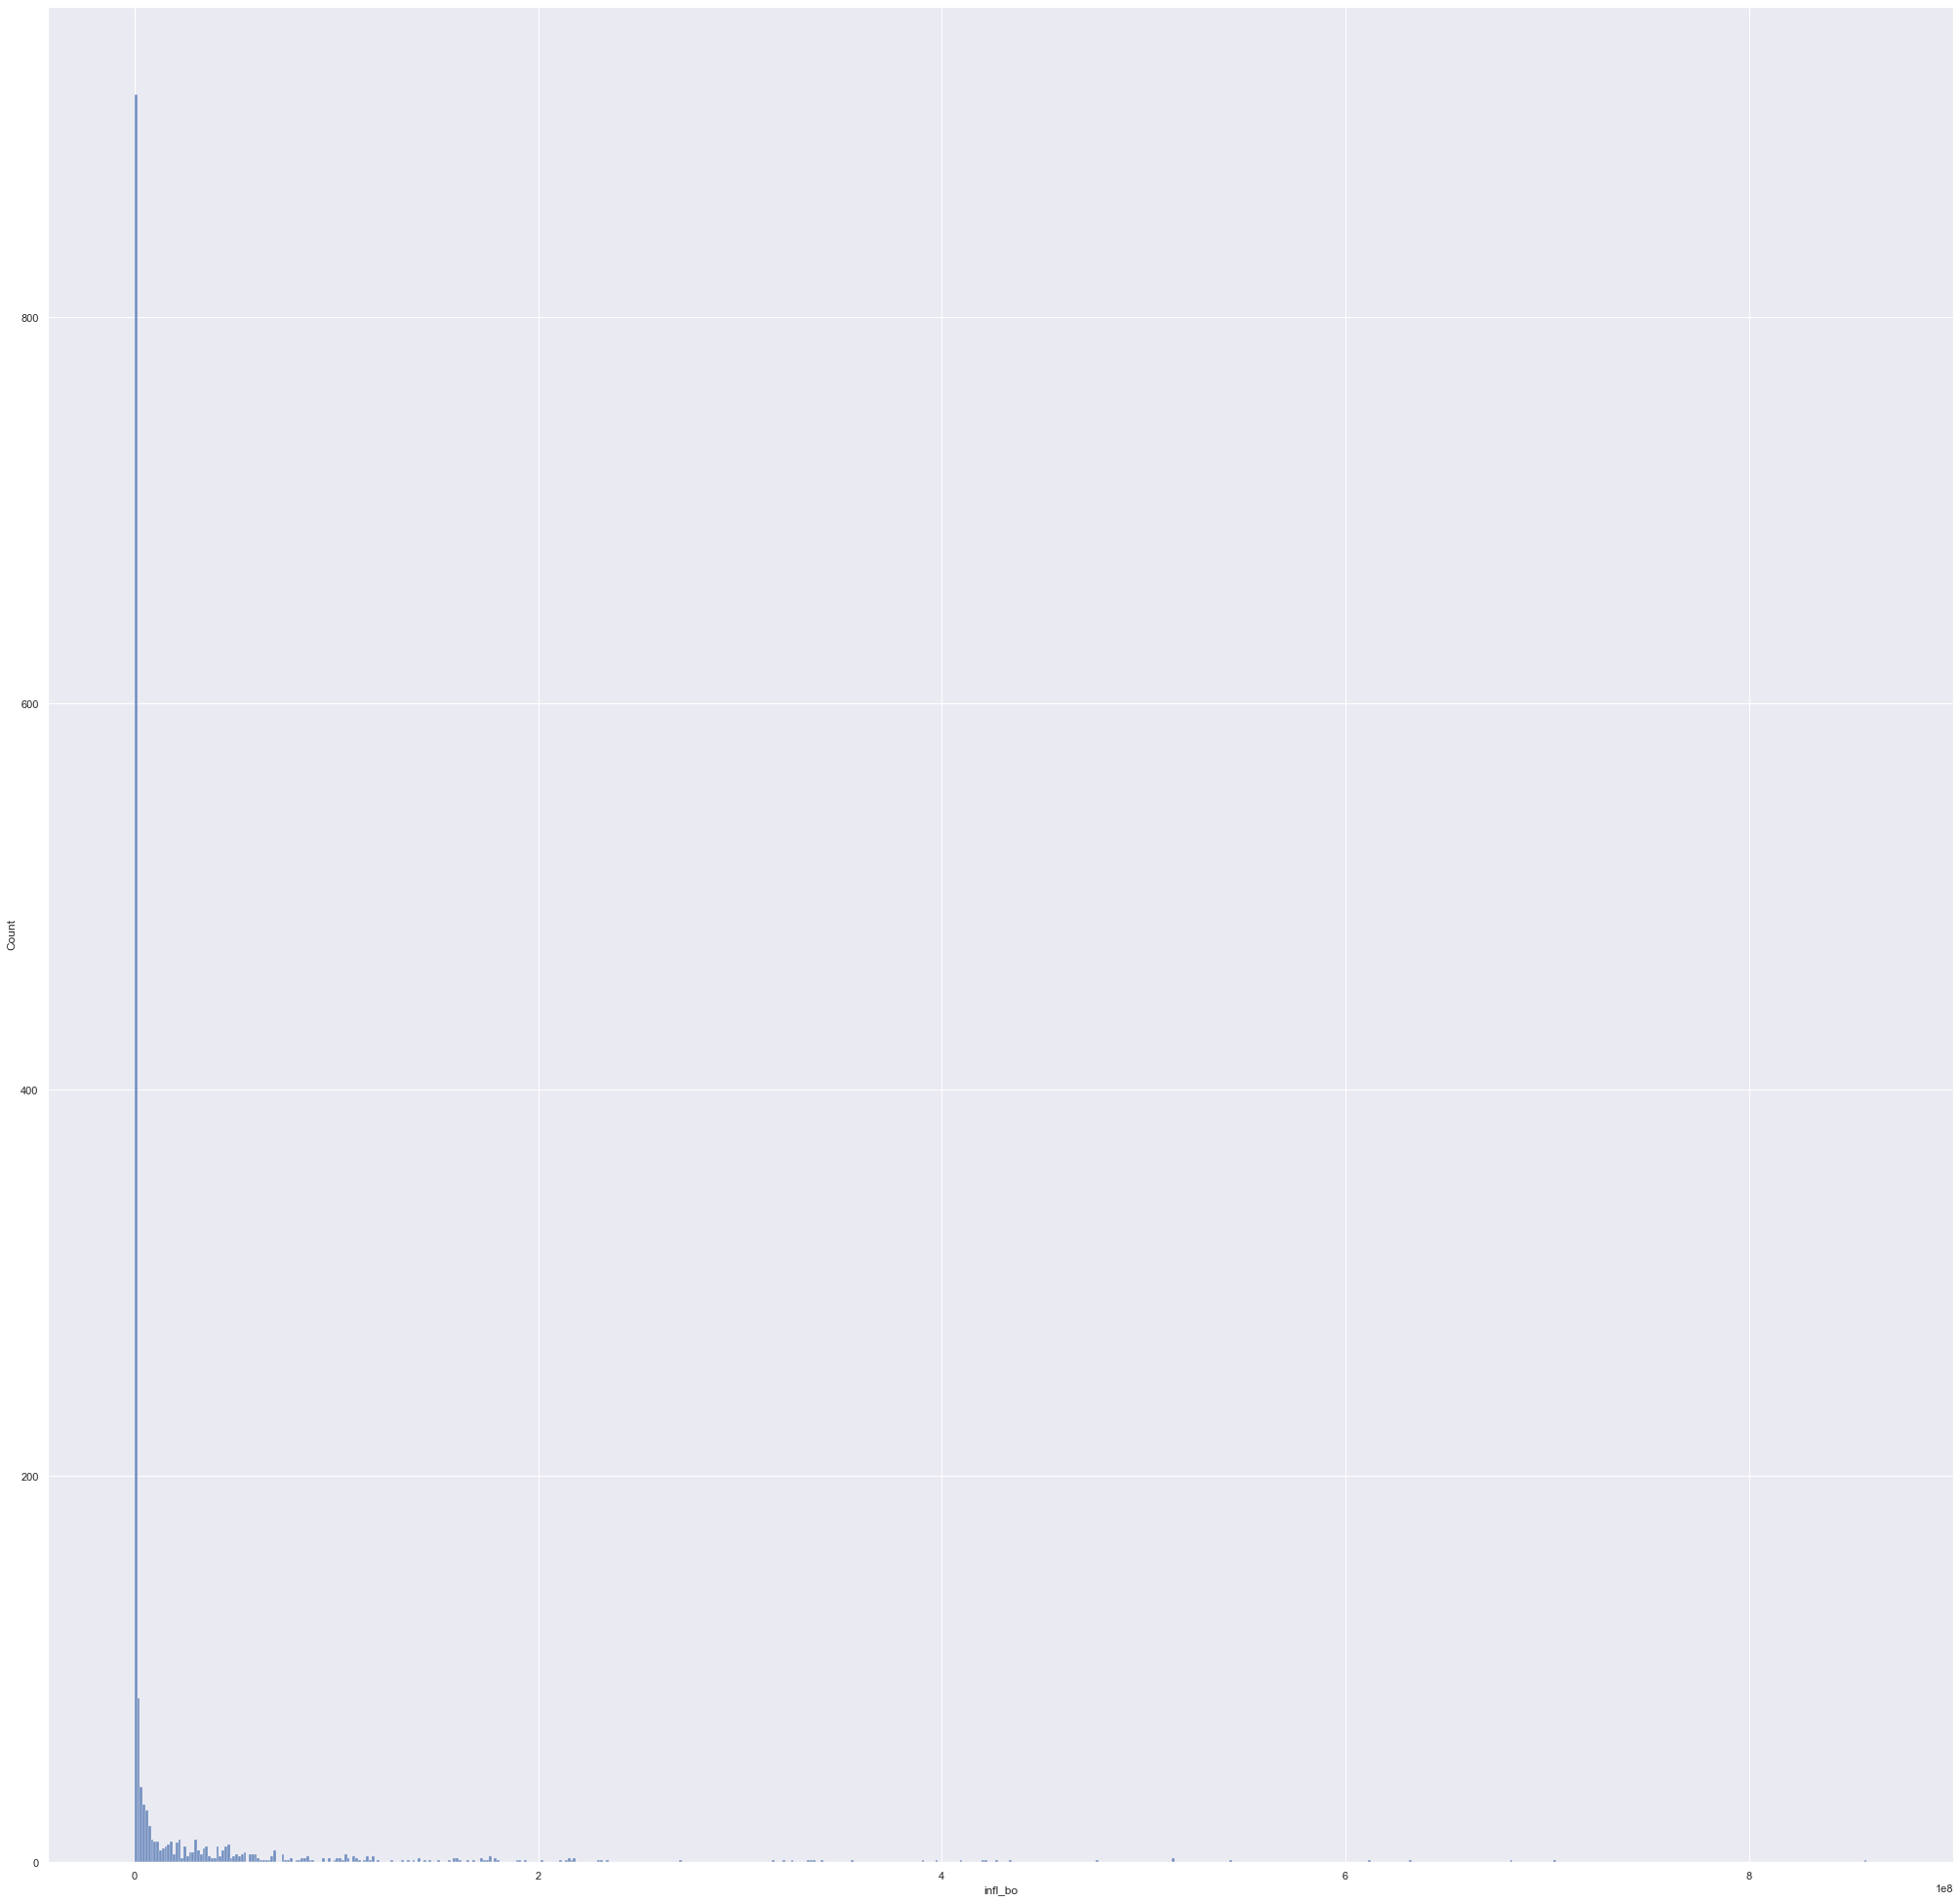

In [16]:
sns.histplot(df['infl_bo'], stat='count')

* huge outliers skewing box office!

In [67]:
top_distributor= df.groupby('distributor', as_index = True)[
    'infl_bo'].mean().sort_values(ascending=False)[:5].index
df['top_distributor'] = df['distributor'].apply(lambda x: "other" if x
                                                not in top_distributor else x)
df["disney"]= df['distributor'].apply(lambda x: 1 if x== "Walt Disney" else 0)


top_production_method = df.groupby('production_method', as_index=True)[
    'infl_bo'].mean().sort_values(ascending=False)[:5].index.to_list()


top_creative = df.groupby('creative_type', as_index=True)[
    'infl_bo'].mean().sort_values(ascending=False)[:5].index.to_list()
df['top_creative'] = df['creative_type'].apply(lambda x: "other" if x
                                                not in top_creative else x)


top_genre = df.groupby('genre', as_index = True)[
    'infl_bo'].mean().sort_values(ascending=False)[:8].index.to_list()
df['top_genre'] = df['genre'].apply(lambda x: "other" if x
                                                not in top_genre else x)



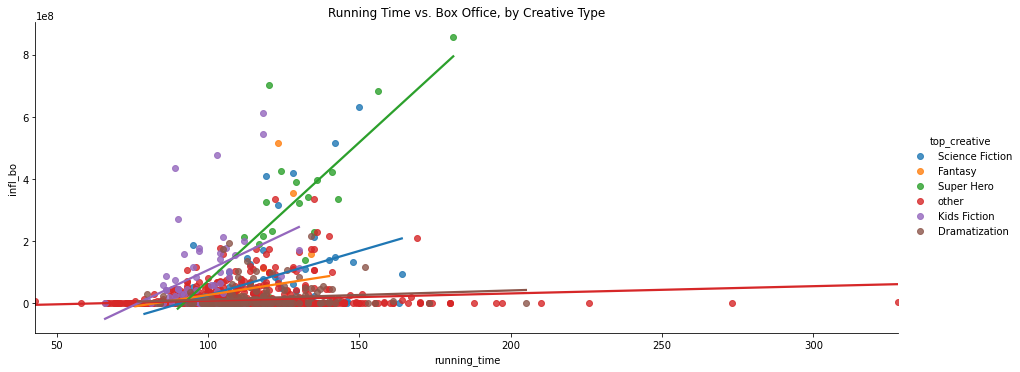

In [73]:
sns.lmplot(x='running_time', 
           y='infl_bo', 
           hue='top_creative', 
           data=df, 
           ci=None, 
           height=5, 
           aspect=2.5);
plt.title("Running Time vs. Box Office, by Creative Type")
plt.savefig("figures/running_time_interaction1.png");

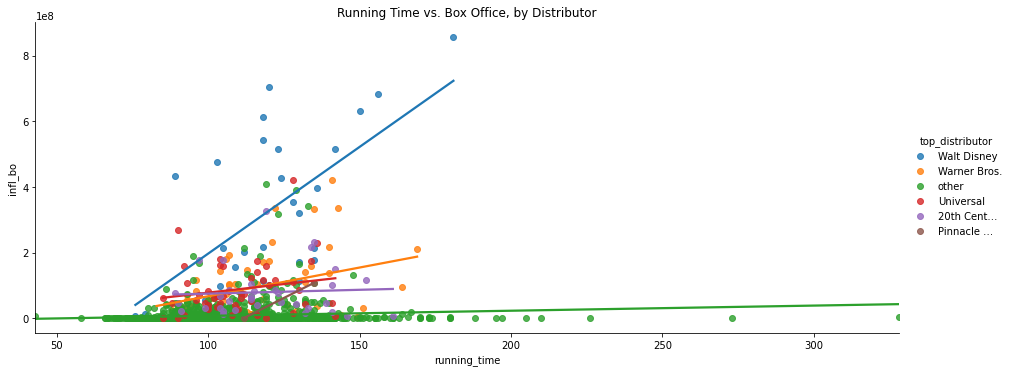

In [74]:
sns.lmplot(x='running_time', 
           y='infl_bo', 
           hue='top_distributor', 
           data=df, 
           ci=None, 
           height=5, 
           aspect=2.5);
plt.title("Running Time vs. Box Office, by Distributor")
plt.savefig("figures/running_time_interaction2.png");

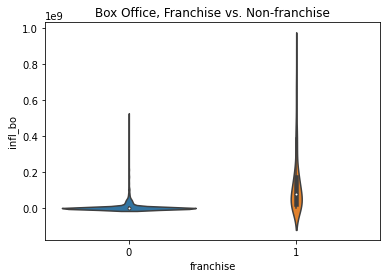

In [75]:
sns.violinplot(x='franchise', y='infl_bo', data=df)
plt.title("Box Office, Franchise vs. Non-franchise")
plt.savefig("figures/bo_dist_franchise.png")

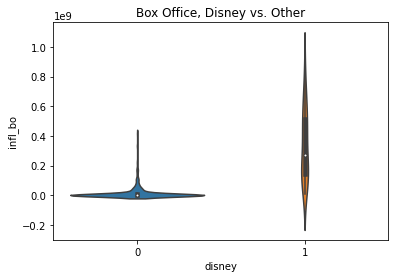

In [82]:
sns.violinplot(x='disney', y='infl_bo', data=df)
plt.title("Box Office, Disney vs. Other")
plt.savefig("figures/bo_disney.png", transparent=True)

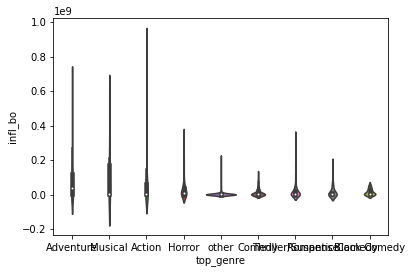

In [76]:
sns.violinplot(x='top_genre', y='infl_bo', data=df)
plt.savefig("figures/genre_box.png", transparent=True);

* There are major outliers! all data is right-skewed.

* disney superhero franchise drives the superhero category and disney's box office metrics

In [11]:
mpaa_ratings = df.groupby('mpaa_rating')['infl_bo'].mean().sort_values(ascending=False)

In [12]:
df.groupby('mpaa_rating')['infl_bo'].mean().sort_values(ascending=False)[:10]

mpaa_rating
G(Rating    7.036750e+07
PG-13       5.978404e+07
PG          5.934596e+07
R           1.927455e+07
Not         3.325482e+05
GP          5.321000e+04
G           4.320300e+04
Name: infl._adj._dom._bo, dtype: float64

In [13]:
df['mpaa_rating'] = df['mpaa_rating'].apply(lambda x: 'G' if x[0]=='G' else x)
df['mpaa_rating'].value_counts()

Not      663
R        410
PG-13    267
PG       129
G         12
Name: mpaa_rating, dtype: int64

<AxesSubplot:xlabel='mpaa_rating', ylabel='infl._adj._dom._bo'>

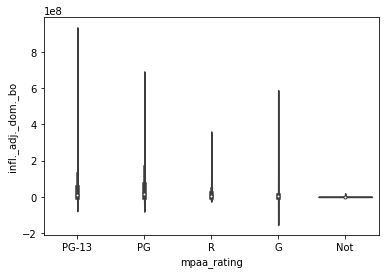

In [14]:
sns.violinplot(x='mpaa_rating', y='infl_bo', data=df)

In [7]:
df.groupby(['lead_actor', 'distributor', 'source'])['infl._adj._dom._bo'].mean().sort_values(ascending=False)[:10]

lead_actor          distributor   source                             
Robert Downey, Jr.  Walt Disney   Based on Comic/Graphic Novel           770457071.5
Chadwick Boseman    Walt Disney   Based on Comic/Graphic Novel           703901821.0
Craig T. Nelson     Walt Disney   other                                  611921929.0
Mark Hamill         Walt Disney   other                                  573452296.5
Donald Glover       Walt Disney   Remake                                 543638043.0
Emma Watson         Walt Disney   Remake                                 514690049.0
Kristen Bell        Walt Disney   Based on Folk Tale/Legend/Fairytale    477373578.0
Tom Hanks           Walt Disney   other                                  434038008.0
Brie Larson         Walt Disney   Based on Comic/Graphic Novel           426829839.0
Gal Gadot           Warner Bros.  Based on Comic/Graphic Novel           421302210.0
Name: infl._adj._dom._bo, dtype: float64

In [73]:
df.groupby(['distributor', 'genre'])['infl._adj._dom._bo'].mean().sort_values(ascending=False)[:10]

distributor   genre    
Walt Disney   Action       5.156036e+08
              Musical      3.006145e+08
              Adventure    3.002184e+08
20th Cent…    Musical      1.760666e+08
Warner Bros.  Action       1.603274e+08
Universal     Adventure    1.464925e+08
20th Cent…    Action       1.338915e+08
Universal     Action       1.335114e+08
Warner Bros.  Horror       1.326899e+08
              Adventure    1.050152e+08
Name: infl._adj._dom._bo, dtype: float64

In [31]:
df.groupby(['disney/warner', 'franchise'])['infl._adj._dom._bo'].mean().sort_values(ascending=False)[:10]

disney/warner  franchise
Disney/Warner  1            2.618034e+08
other          1            8.226225e+07
Disney/Warner  0            7.903855e+07
other          0            7.009312e+06
Name: infl._adj._dom._bo, dtype: float64

In [34]:
df.groupby(['movie', 'disney/warner', 'franchise'])['infl._adj._dom._bo'].mean().sort_values(ascending=False)[:10]

movie                              disney/warner  franchise
Avengers: Endgame                  Disney/Warner  1            858373002.0
Black Panther                      Disney/Warner  1            703901821.0
Avengers: Infinity War             Disney/Warner  1            682541141.0
Star Wars Ep. VIII: The Last Jedi  Disney/Warner  1            631702051.0
Incredibles 2                      Disney/Warner  1            611921929.0
The Lion King                      Disney/Warner  1            543638043.0
Star Wars: The Rise of Skywalker   Disney/Warner  1            515202542.0
Beauty and the Beast               Disney/Warner  0            514690049.0
Frozen II                          Disney/Warner  1            477373578.0
Toy Story 4                        Disney/Warner  1            434038008.0
Name: infl._adj._dom._bo, dtype: float64

In [35]:
df.groupby(['movie', 'disney/warner', 'creative_type'])['infl._adj._dom._bo'].mean().sort_values(ascending=False)[:10]

movie                              disney/warner  creative_type
Avengers: Endgame                  Disney/Warner  Super Hero       858373002.0
Black Panther                      Disney/Warner  Super Hero       703901821.0
Avengers: Infinity War             Disney/Warner  Super Hero       682541141.0
Star Wars Ep. VIII: The Last Jedi  Disney/Warner  other            631702051.0
Incredibles 2                      Disney/Warner  other            611921929.0
The Lion King                      Disney/Warner  other            543638043.0
Star Wars: The Rise of Skywalker   Disney/Warner  other            515202542.0
Beauty and the Beast               Disney/Warner  other            514690049.0
Frozen II                          Disney/Warner  other            477373578.0
Toy Story 4                        Disney/Warner  other            434038008.0
Name: infl._adj._dom._bo, dtype: float64

In [ ]:
df.groupby(['distributor', 'superhero'])['infl._adj._dom._bo'].mean().sort_values(ascending=False)[:10]

* actors, directors are likely not driving box office success-- it's more so the franchise or distributor
* might leave these out of the regression for fear of introducing multicollinearity.

## Categorical Variables

In [4]:
# determining top 5 for each categorical variable by avg. infl-adjusted box office.

#create quartiles for distribution company by avg. dom bo
dist_quart = pd.DataFrame(df.groupby('distributor')[
    'infl_bo'].mean().sort_values(ascending=False))
dist_quart["dist_quartile"] = pd.qcut(
    dist_quart["infl_bo"], q=4, labels=["quar_1","quar_2","quar_3","quar_4"])

#separate Disney from other major distributors--Marvel Franchise
df["dist_quartile"] = df['distributor'].apply(
    lambda x: "quar_5" if x=="Walt Disney" else dist_quart.loc[x, "dist_quartile"])


top_genre = df.groupby('genre', as_index = True)[
    'infl_bo'].mean().sort_values(ascending=False)[:8].index.to_list()
df['genre'] = df['genre'].apply(lambda x: "other" if x not in top_genre else x)
df['genre'] = df['genre'].apply(lambda x: "Action/Adventure" if x == "Action" or x== "Adventure" else x)
df['genre'] = df['genre'].apply(lambda x: "Comedy" if "Comedy" in x else x)

top_source = df.groupby('source', as_index = True)[
    'infl_bo'].mean().sort_values(ascending=False)
df['source'] = df['source'].apply(lambda x: "adaptation" if x[0] == 'B' else x)
df['source'] = df['source'].apply(lambda x: "original" if x[0] == '0' else x)
df['source'] = df['source'].apply(lambda x: "remake/spinoff" if x[0] == 'S' or x[0] == 'R' else x)


top_creative_type = df.groupby('creative_type', as_index= True)[
    'infl_bo'].mean().sort_values(ascending=False)[:5].index.to_list()
df['creative_type'] = df['creative_type'].apply(lambda x: "other" if 
                                                x != "Super Hero" and x != "Kids Fiction"else x)

top_production_method = df.groupby('production_method', as_index=True)[
    'infl_bo'].mean().sort_values(ascending=False)[:5].index.to_list()
animated = ['Digital Animation', 'Stop-Motion Animation', 'Hand Animation', 'Rotoscoping',]
hybrid = ['Animation/Live Action', 'Multiple Production Methods']

df['production_method'] = df['production_method'].apply(lambda x: "animated" if x in animated else x)
df['production_method'] = df['production_method'].apply(lambda x: "hybrid" if x in hybrid else x)

#leave mpaa out because there are only 6 unique values to begin with


<AxesSubplot:xlabel='dist_quartile', ylabel='infl_bo'>

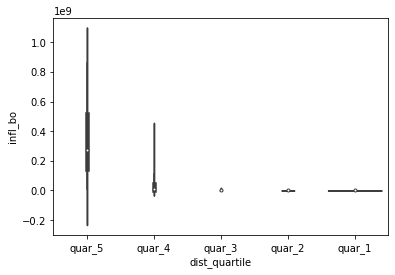

In [81]:
sns.violinplot(x='dist_quartile', y='infl_bo', data=df)


<AxesSubplot:xlabel='source', ylabel='infl._adj._dom._bo'>

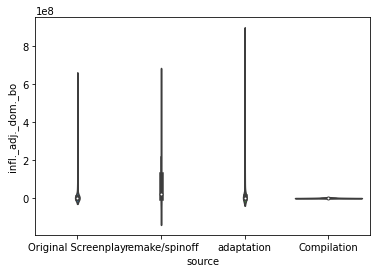

In [9]:
sns.violinplot(x='source', y='infl_bo', data=df)

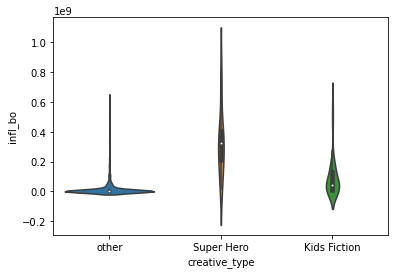

In [80]:
sns.violinplot(x='creative_type', y='infl_bo', data=df)
plt.savefig("figures/creative_box.png", transparent=True);

In [5]:
#creating dt year variable and holiday dummy variable
import datetime as dt
from datetime import timedelta, date
df["year"]= df.release_date.dt.year
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=df['release_date'].min(),
                        end=df['release_date'].max()).to_pydatetime()

for i in holidays:
    holidays =np.append(holidays, (i - timedelta(1)))
    holidays =np.append(holidays, (i - timedelta(2)))
    holidays= np.append(holidays, (i - timedelta(3)))
    holidays= np.append(holidays, (i + timedelta(1)))
    holidays= np.append(holidays, (i + timedelta(2)))
    holidays= np.append(holidays, (i + timedelta(3)))
    
df['holiday'] = df['release_date'].isin(holidays)
df['holiday'] = df['holiday'].apply(lambda x: 1 if x=="True" else 0)
df['yr_2018'] = df['year'].apply(lambda x: 1 if x==2018 else 0)
df['yr_2019']= df['year'].apply(lambda x: 1 if x==2019 else 0)


## Building the Features dataset to train and test on 

In [6]:
feature_df = pd.get_dummies(df[[
    'genre', 'production_method', 'source', 'dist_quartile', 'creative_type']])
feature_df['holiday']=df['holiday']
feature_df["op_wknd_total_gross_share"]= df["op_wknd_total_gross_share"]
feature_df["legs"]=df["legs"]
feature_df["domestic_share"]= df["domestic_share"]
feature_df["running_time"]= df["running_time"]
feature_df['yr_2018']=df['yr_2018']
feature_df['yr_2019']=df['yr_2019']
feature_df['franchise']=df['franchise']

#non-disney superhero
feature_df['hero_franchise']= feature_df["creative_type_Super Hero"]*feature_df["franchise"]
feature_df['disney_franchise']=feature_df['franchise']*feature_df['dist_quartile_quar_5']

conditions = [(feature_df['hero_franchise'] ==1) & (feature_df['dist_quartile_quar_5'] ==0),
              (feature_df['hero_franchise'] ==1) & (feature_df['dist_quartile_quar_5'] ==1)]
values = [1, 0]
feature_df['hero_franchise']= np.select(conditions, values)


#non-disney kids films
feature_df['kids_animated']=feature_df[
    "creative_type_Kids Fiction"]*feature_df["production_method_animated"]

conditions = [(feature_df['kids_animated'] ==1) & (feature_df['dist_quartile_quar_5'] ==0),
              (feature_df['kids_animated'] ==1) & (feature_df['dist_quartile_quar_5'] ==1)]
values = [1, 0]

feature_df['kids_animated']= np.select(conditions, values)

In [7]:
feature_df['disney_franchise'].value_counts()

0    1461
1      20
Name: disney_franchise, dtype: int64

In [8]:
feature_df.columns.to_list()

['genre_Action/Adventure',
 'genre_Comedy',
 'genre_Horror',
 'genre_Musical',
 'genre_Thriller/Suspense',
 'genre_other',
 'production_method_Live Action',
 'production_method_animated',
 'production_method_hybrid',
 'source_Compilation',
 'source_Original Screenplay',
 'source_adaptation',
 'source_remake/spinoff',
 'dist_quartile_quar_1',
 'dist_quartile_quar_2',
 'dist_quartile_quar_3',
 'dist_quartile_quar_4',
 'dist_quartile_quar_5',
 'creative_type_Kids Fiction',
 'creative_type_Super Hero',
 'creative_type_other',
 'holiday',
 'op_wknd_total_gross_share',
 'legs',
 'domestic_share',
 'running_time',
 'yr_2018',
 'yr_2019',
 'franchise',
 'hero_franchise',
 'disney_franchise',
 'kids_animated']

In [11]:
feature1= feature_df.drop(
    columns = ['genre_other', 'genre_Thriller/Suspense',
               'production_method_Live Action', 'production_method_animated',
               'source_Compilation', 'source_adaptation',
               "creative_type_Super Hero", "creative_type_other",
               'creative_type_Kids Fiction', 'creative_type_Super Hero',
               'dist_quartile_quar_5', 'creative_type_Kids Fiction'])

# Simple Validation

In [12]:
X = feature1

In [13]:
y = df['infl_bo']
y.shape

(1481,)

In [14]:
from sklearn.model_selection import KFold
#extracting test data
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=0) #hold out 20% of the data for final testing
#extracting validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [15]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                infl_bo   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     63.02
Date:                Wed, 23 Feb 2022   Prob (F-statistic):          3.61e-158
Time:                        11:12:55   Log-Likelihood:                -16755.
No. Observations:                 888   AIC:                         3.355e+04
Df Residuals:                     866   BIC:                         3.366e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         1.1e+08   1.95e+07      5.629      0.000    7.16e+07    1.48e+08
genre_Action/Adventure       1.58e+07   4.62e+06      3.417      0.001    6.72e+06    2.49e+07
genre_Comedy                  2.6e+06   3.91e+06      0.665      0.507   -5.08e+06    1.03e+07
genre_Horror                5.945e+06   6.18e+06      0.962      0.336   -6.18e+06    1.81e+07
genre_Musical                7.87e+06   1.77e+07      0.445      0.657   -2.69e+07    4.26e+07
production_method_hybrid    1.878e+07    8.8e+06      2.133      0.033     1.5e+06    3.61e+07
source_Original Screenplay -1.702e+06   2.77e+06     -0.615      0.539   -7.13e+06    3.73e+06
source_remake/spinoff       9.268e+06   8.83e+06      1.050      0.294   -8.05e+06    2.66e+07
dist_quartile_quar_1       -1.252e+08   1.84e+07     -6.791      0.000   -1.61e+08    -8.9e+07
dist_quartile_quar_2       -1.268e+08   1.83e+07     -6.929      0.000   -1.63e+08   -9.09e+07
dist_quartile_quar_3       -1.305e+08   1.82e+07     -7.173      0.000   -1.66e+08   -9.48e+07
dist_quartile_quar_4       -1.084e+08   1.81e+07     -5.987      0.000   -1.44e+08   -7.28e+07
holiday                     3.264e-08   1.62e-08      2.015      0.044    8.43e-10    6.44e-08
op_wknd_total_gross_share    -9.6e+04   5.89e+04     -1.631      0.103   -2.12e+05    1.95e+04
legs                        8564.6225   9.18e+04      0.093      0.926   -1.72e+05    1.89e+05
domestic_share              1.515e+04   3.77e+04      0.402      0.688   -5.88e+04    8.91e+04
running_time                1.702e+05   6.65e+04      2.559      0.011    3.97e+04    3.01e+05
yr_2018                     1.973e+06   3.13e+06      0.630      0.529   -4.18e+06    8.12e+06
yr_2019                    -3.715e+05   3.23e+06     -0.115      0.908   -6.71e+06    5.96e+06
franchise                   5.468e+07   5.53e+06      9.895      0.000    4.38e+07    6.55e+07
hero_franchise              1.212e+08    2.3e+07      5.277      0.000    7.61e+07    1.66e+08
disney_franchise            1.794e+08   2.24e+07      8.014      0.000    1.35e+08    2.23e+08
kids_animated               5.523e+05   8.95e+06      0.062      0.951    -1.7e+07    1.81e+07
==============================================================================
Omnibus:                      615.056   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32907.602
Skew:                           2.512   Prob(JB):                         0.00
Kurtosis:                      32.396   Cond. No.                     1.97e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.65e-32

In [16]:
def clean_add_int(df):
    try:
        if "const" in df.columns.to_list():
            df.drop(columns='const', inplace=True)
    except:
        pass
    
    df.drop(columns = ['genre_Comedy', 'genre_Horror','genre_Musical',
                       'source_Original Screenplay', 'kids_animated',
                       "source_remake/spinoff", 'yr_2018', 'domestic_share',
                       'legs', "yr_2019", 'holiday', "op_wknd_total_gross_share", 'dist_quartile_quar_4'],
            inplace=True)
    return(df)

def add_sq(df):
    df_sq = df.copy()
    df["running_time_sq"]=df["running_time"]**2
    df.drop(columns= ["running_time"], inplace=True)
    return(df_sq)

def log_runtime(df):
    df['runtime_log']=np.log(np.sqrt(df["running_time_sq"]))
    df.drop(columns= ["running_time_sq"], inplace=True)
    return(df)


def scal_df(df):
    df_scal = scaler.fit_transform(df)
    return(df_scal)

## Feature Selection ctd. Lasso Reg

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


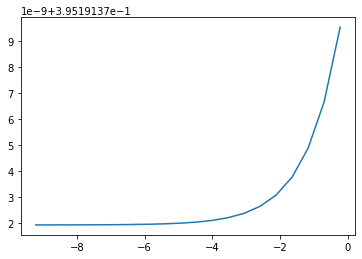

In [17]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
scaler = StandardScaler()

clean_add_int(X_train)
clean_add_int(X_val)
X_tr_sca= scaler.fit_transform(X_train)

X_val_sca= scaler.transform(X_val)

#this kf spec is taken from the Lasso Exercise
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kf, 
                        return_train_score=False)
grid_est.fit(X_tr_sca, y_train)
df_lasso = pd.DataFrame(grid_est.cv_results_)
df_lasso["alpha"] = df_lasso.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df_lasso.alpha), df_lasso.mean_test_score);


In [18]:
grid_est.best_estimator_

Lasso(alpha=0.7943282347242815)

In [19]:
lasso_model = Lasso(alpha = 0.794328234724281)
lasso_model.fit(X_tr_sca, y_train)

Lasso(alpha=0.794328234724281)

In [20]:
print(lasso_model.score(X_tr_sca, y_train), lasso_model.score(X_val_sca, y_val))

0.5834648881739253 0.6703244612202877


In [21]:
lasso_results = pd.DataFrame()
lasso_results['predict']=lasso_model.predict(X_tr_sca)
lasso_results['resid']=y_train - lasso_model.predict(X_tr_sca)
mae_train_lasso = round(sum(abs(y_train - lasso_model.predict(X_tr_sca)))/len(y_train), 2)
mae_val_lasso = round(sum(abs(y_val - lasso_model.predict(X_val_sca)))/len(y_val), 2)
print(mae_train_lasso, mae_val_lasso)

16505767.23 19505552.63


In [22]:
lasso_model.coef_

array([  5399542.56375352,   4906037.14530072,  -6870562.5455105 ,
        -8277861.27686453, -10620316.25988081,   2967888.22615768,
        14631180.30368653,   6918006.26891911,  28599751.9594667 ])

In [25]:
print(mae_train_lasso, mae_val_lasso)



16505767.23 19505552.63


In [106]:
y.describe()

count    1.184000e+03
mean     1.954908e+07
std      6.601238e+07
min      4.490000e+02
25%      3.870725e+04
50%      3.415910e+05
75%      6.622245e+06
max      8.583730e+08
Name: infl._adj._dom._bo, dtype: float64

## Cross Validation

In [27]:
X=feature1
y = df['infl_bo']

In [28]:

from sklearn.model_selection import KFold
#extracting test data
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=0) #hold out 20% of the data for final testing



In [29]:
X.columns.to_list()

['genre_Action/Adventure',
 'genre_Comedy',
 'genre_Horror',
 'genre_Musical',
 'production_method_hybrid',
 'source_Original Screenplay',
 'source_remake/spinoff',
 'dist_quartile_quar_1',
 'dist_quartile_quar_2',
 'dist_quartile_quar_3',
 'dist_quartile_quar_4',
 'holiday',
 'op_wknd_total_gross_share',
 'legs',
 'domestic_share',
 'running_time',
 'yr_2018',
 'yr_2019',
 'franchise',
 'hero_franchise',
 'disney_franchise',
 'kids_animated']

In [30]:
lm = LinearRegression()
scoring = 'neg_mean_absolute_error'

#linear regression with superhero interaction term

clean_add_int(X)
cv_lm_mae= abs(cross_val_score(lm, X, y, cv=5, scoring = scoring))

#linear regression with squared running time

add_sq(X)
cv_lm_sq_mae= abs(cross_val_score(lm, X, y, cv=5, scoring = scoring))

#linear regression with log running time
log_runtime(X)
cv_lm_log_mae= abs(cross_val_score(lm, X, y, cv=5, scoring = scoring))

#lasso regression
scal_df(X)

cv_lasso_mae= abs(cross_val_score(Lasso(alpha = 0.7943282347242815),
                                    X, y, cv=5, scoring = scoring))


/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-16-ef22ff7c8777>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["running_time_sq"]=df["running_time"]**2
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [31]:

print("simple model cvs: {}".format(cv_lm_mae))
print("squared model cvs: {}".format(cv_lm_sq_mae))
print("log model cvs: {}".format(cv_lm_log_mae))
print("lasso model cvs: {}".format(cv_lasso_mae))

print("simple model mean: {}".format(round(np.mean(cv_lm_mae),2)),
      "squared model mean: {}".format(round(np.mean(cv_lm_sq_mae), 2)),
      "log model mean: {}".format(round(np. mean(cv_lm_log_mae),2)),
      "lasso model mean: {}".format(round(np. mean(cv_lasso_mae),2)))

print("simple model std dv: {}".format(round(cv_lm_mae.std(), 2)), 
      "squared model std dv: {}".format(round(cv_lm_sq_mae.std(),2)),
      "log model std dv: {}".format(round(cv_lm_log_mae.std(),2)),
      "lasso model std dv: {}".format(round(cv_lasso_mae.std(),2)))


simple model cvs: [20410552.6030916  14027632.66579961 20285994.77255283 17402271.13062365
 17360869.93516609]
squared model cvs: [20048995.31540316 13723597.64553188 20217061.48676565 16739709.11830153
 16924990.14192965]
log model cvs: [20735636.82024416 14158189.6263841  20285777.1520537  17707730.56191954
 17627445.37834448]
lasso model cvs: [20735635.97527099 14158187.02798462 20285774.22726689 17707730.88302298
 17627444.53929447]
simple model mean: 17897464.22 squared model mean: 17530870.74 log model mean: 18102955.91 lasso model mean: 18102954.53
simple model std dv: 2346462.75 squared model std dv: 2410183.75 log model std dv: 2351136.39 lasso model std dv: 2351136.56


*squared model is best

## Fit model on test set

In [32]:
X=feature1
y = df['infl_bo']
X, X_test, y, y_test = train_test_split(
    X, y, test_size=.2, random_state=0) #hold out 20% of the data for final testing

In [33]:
clean_add_int(X)
add_sq(X)
clean_add_int(X_test)
add_sq(X_test)

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-16-ef22ff7c8777>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["running_time_sq"]=df["running_time"]**2


,genre_Action/Adventure,production_method_hybrid,dist_quartile_quar_1,dist_quartile_quar_2,dist_quartile_quar_3,running_time,franchise,hero_franchise,disney_franchise
567,0,0,0,0,0,110.0,0,0,0
1041,0,0,0,0,0,121.0,0,0,0
649,0,0,0,0,0,98.0,1,0,0
666,0,0,0,0,1,110.0,0,0,0
568,0,0,0,0,0,132.0,0,0,0
...,...,...,...,...,...,...,...,...,...
1090,0,0,0,0,0,147.0,0,0,0
1470,0,0,0,0,1,85.0,0,0,0
665,0,0,0,0,0,95.0,0,0,0
1055,1,0,0,0,0,102.0,0,0,0


In [34]:
fit_final = lm.fit(X, y)
final_r2_train = lm.score(X, y)
final_r2 = lm.score(X_test, y_test)
mae_final = round(sum(abs(y - fit_final.predict(X)))/len(y), 2)
mae_test = round(sum(abs(y_test - fit_final.predict(X_test)))/len(y_test), 2)

In [35]:
print(final_r2_train, final_r2)
print(mae_final, mae_test)

0.626719131004069 0.5006203487061032
16894208.55 24015754.78


In [36]:
X.columns.to_list()

['genre_Action/Adventure',
 'production_method_hybrid',
 'dist_quartile_quar_1',
 'dist_quartile_quar_2',
 'dist_quartile_quar_3',
 'franchise',
 'hero_franchise',
 'disney_franchise',
 'running_time_sq']

In [39]:
X.rename(columns = {"genre_Action/Adventure":"Action/Adventure", "production_method_hybrid":"Live Action/CGI",
                    "dist_quartile_quar_3":'3q_distributor',
                    "dist_quartile_quar_2":'2q_distributor',
                    "dist_quartile_quar_1":'1q_distributor'}, inplace=True)

In [40]:
final_reg = pd.DataFrame()
final_reg["coefficients"]= X.columns.to_list()
final_reg["values"] = fit_final.coef_

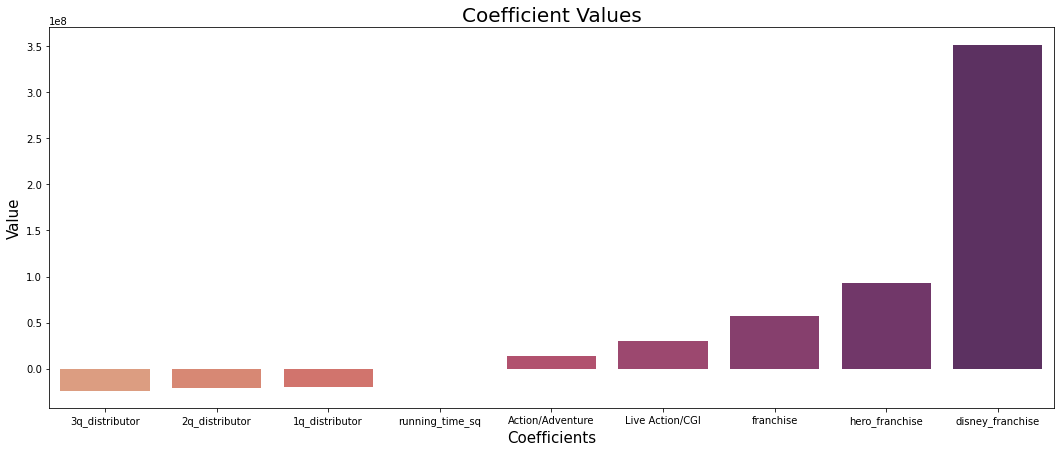

In [46]:
plt.figure(figsize=(18,7))
sns.barplot(x='coefficients', 
           y='values', data=final_reg,
            order= final_reg.sort_values('values').coefficients,
            palette='flare');
plt.title("Coefficient Values", fontsize=20)
plt.xlabel("Coefficients", fontsize=15)
plt.ylabel("Value", fontsize=15)
plt.savefig("figures/reg_coef_val.png", transparent=True);

In [42]:
final_reg_resid = pd.DataFrame()
final_reg_resid['y_holdout']= y_test
final_reg_resid['predicted']= fit_final.predict(X_test)
final_reg_resid['resid']= final_reg_resid['predicted']-final_reg_resid['y_holdout']


/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


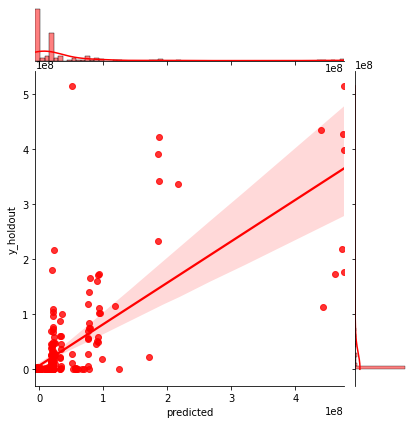

In [47]:
sns.jointplot(
    final_reg_resid['predicted'], final_reg_resid['y_holdout'],
    kind='reg', color='r')

plt.savefig("figures/results_final.png", transparent=True)